# Классификация ирисов с использованием Numpy

В этом ноутбуке работаем с датасетом Iris для решения задачи классификации видов ирисов по различным признакам. Необходимо реализовать: загрузку Iris, представление данных в матрицах, нормализацию, категоризацию по квантилям, разделение выборки, обучение классификатора, проведение 3 экспериментов, визуализацию с помощью РСА и t-SNE с отображением оригинальных и предсказанных меток

## Описание датасета Iris

Датасет содержит измерения 150 цветков ириса трех видов:
- Setosa, Versicolor, Virginica

Признаки (в сантиметрах):
- длина чашелистика (sepal length)
- ширина чашелистика (sepal width) 
- длина лепестка (petal length)
- ширина лепестка (petal width)

## 1. Получение датасета Iris

In [103]:
import numpy as np
import matplotlib.pyplot as plt

data = np.genfromtxt('Загрузки/iris.data.csv', delimiter=',', dtype=None, encoding=None)
print(data.shape, np.unique(data[4]))
for i in range(5):
    print(data[i])

(150,) [(5., 3.6, 1.4, 0.2, 'Iris-setosa')]
(5.1, 3.5, 1.4, 0.2, 'Iris-setosa')
(4.9, 3.0, 1.4, 0.2, 'Iris-setosa')
(4.7, 3.2, 1.3, 0.2, 'Iris-setosa')
(4.6, 3.1, 1.5, 0.2, 'Iris-setosa')
(5.0, 3.6, 1.4, 0.2, 'Iris-setosa')


## 2. Подготовка данных

Извлекаем признаки (столбцы 0-3) и классы (столбец 4), преобразуем названия видов в числа (0, 1, 2)

In [104]:
X = np.array([list(row)[:4] for row in data], dtype=float)
names = np.array([list(row)[4] for row in data])

unique_names, y = np.unique(names, return_inverse=True)
iris_names = unique_names.tolist()

print(X.shape, y.shape, iris_names)
print(f"Общий размер в байтах: {X.nbytes + y.nbytes}")

(150, 4) (150,) ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Общий размер в байтах: 6000


## 3. Нормализация

Приводим признаки к диапазону [0, 1] по формуле: (X - min) / (max - min)

In [105]:
X_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

print(X_norm.min(), X_norm.max())

0.0 1.0


## 4. Категоризация признака

Разделяем первый признак на три категории по квантилям

In [106]:
first = X[:, 0]
q25 = np.percentile(first, 25)
q75 = np.percentile(first, 75)

cat = np.where(first < q25, 'small',
               np.where(first > q75, 'big', 'medium'))

print(f"q25={q25}, q75={q75}")
print(f"Распределение: {dict(zip(*np.unique(cat, return_counts=True)))}")

q25=5.1, q75=6.4
Распределение: {np.str_('big'): np.int64(35), np.str_('medium'): np.int64(83), np.str_('small'): np.int64(32)}


## 5. Разделение данных

Делим на тренировочную (80%) и тестовую (20%) выборки

In [107]:
np.random.seed(11)
indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))
train_idx, test_idx = indices[:train_size], indices[train_size:]

X_train, X_test = X_norm[train_idx], X_norm[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 120, Test: 30


## 6. Классификация SVC

Обучаем SVC с ядром RBF и оцениваем точность на тестовой выборке

In [79]:
clf = SVC(kernel='rbf', random_state=11)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.2%}")
print("\n" + classification_report(y_test, y_pred, target_names=iris_names))

Accuracy: 93.33%

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         9
Iris-versicolor       0.83      1.00      0.91        10
 Iris-virginica       1.00      0.82      0.90        11

       accuracy                           0.93        30
      macro avg       0.94      0.94      0.94        30
   weighted avg       0.94      0.93      0.93        30



При общей точности в 93%, модель имеет высокие показатели f1 >= 90 для каждого класса, а значит, ее предсказательная способность очень велика

## 7. Эксперименты

### Эксперимент 1: Ядра SVC

Тестируем различные ядра (linear, rbf, poly) и сравниваем точность

In [80]:
kernels = ['linear', 'rbf', 'poly']
print("Ядра SVC:")
for k in kernels:
    m = SVC(kernel=k, random_state=11)
    m.fit(X_train, y_train)
    a = accuracy_score(y_test, m.predict(X_test))
    print(f"{k}: {a:.2%}")

Ядра SVC:
linear: 93.33%
rbf: 93.33%
poly: 96.67%


### Эксперимент 2: Нормализация

Сравниваем результаты на нормализованных и ненормализованных данных

In [81]:
X_tr_raw, X_ts_raw, y_tr, y_ts = train_test_split(
    X, y, test_size=0.2, random_state=11
)

m_raw = SVC(kernel='rbf', random_state=11)
m_raw.fit(X_tr_raw, y_tr)
a_raw = accuracy_score(y_ts, m_raw.predict(X_ts_raw))

print(f"Без нормализации: {a_raw:.2%}")
print(f"С нормализацией: {acc:.2%}")

Без нормализации: 93.33%
С нормализацией: 93.33%


### Эксперимент 3: Параметры C и gamma

Тестируем разные значения C и gamma для SVC

In [82]:
print("C и gamma:")
for C in [0.1, 1.0, 10.0]:
    for g in ['scale', 'auto']:
        m = SVC(kernel='rbf', C=C, gamma=g, random_state=11)
        m.fit(X_train, y_train)
        a = accuracy_score(y_test, m.predict(X_test))
        print(f"  C={C}, gamma={g:6s}: {a:.2%}")

C и gamma:
  C=0.1, gamma=scale : 93.33%
  C=0.1, gamma=auto  : 63.33%
  C=1.0, gamma=scale : 93.33%
  C=1.0, gamma=auto  : 93.33%
  C=10.0, gamma=scale : 93.33%
  C=10.0, gamma=auto  : 93.33%


## 8. Визуализация

Применяем PCA для снижения размерности с 4 до 2 компонент, визуализируем оригинальные метки и предсказания

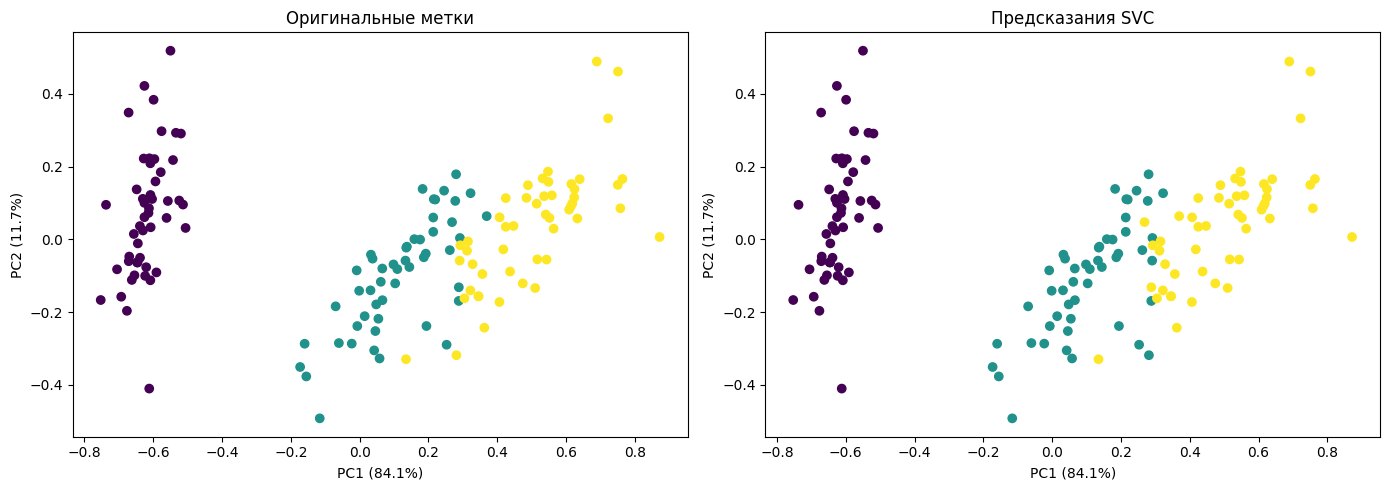

Объясненная дисперсия: 95.87%


In [83]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

y_pred_all = clf.predict(X_norm)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y)
ax[0].set_title('Оригинальные метки')
ax[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_all)
ax[1].set_title('Предсказания SVC')
ax[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

plt.tight_layout()
plt.show()

print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.2%}")

### t-SNE

Применяем t-SNE для нелинейного снижения размерности, сравниваем оригинальные метки и предсказания

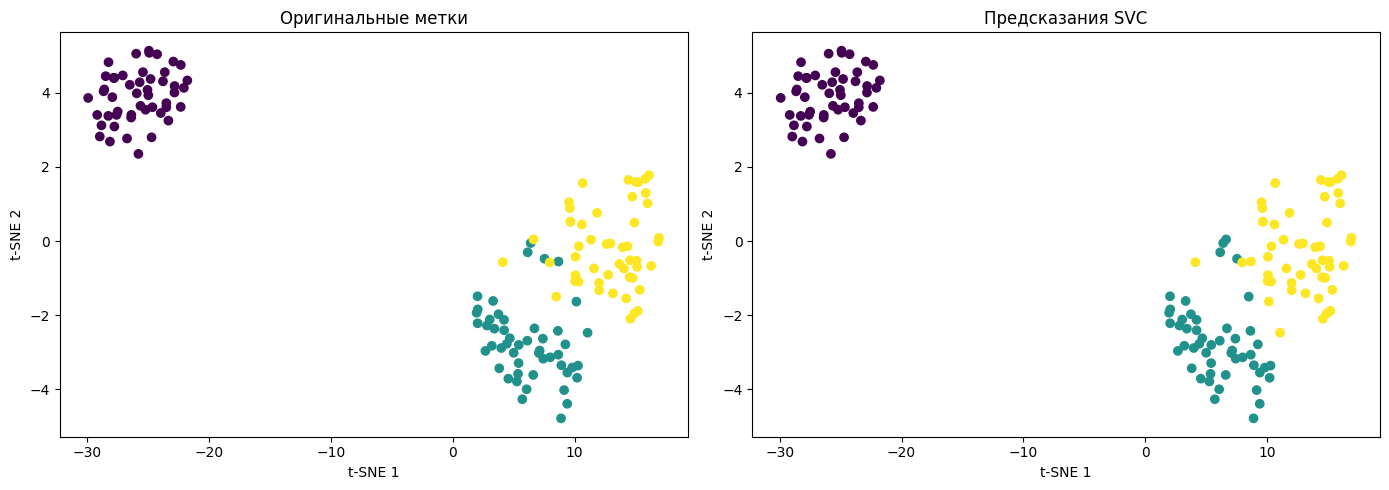

In [84]:
tsne = TSNE(n_components=2, random_state=11, max_iter=1000)
X_tsne = tsne.fit_transform(X_norm)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
ax[0].set_title('Оригинальные метки')
ax[0].set_xlabel('t-SNE 1')
ax[0].set_ylabel('t-SNE 2')

ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred_all)
ax[1].set_title('Предсказания SVC')
ax[1].set_xlabel('t-SNE 1')
ax[1].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()